In [1]:
import os
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from PIL import Image

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
data_dir = tf.keras.utils.get_file(origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname = 'flower_photos', untar = True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 43s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
# Class names are file names

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['dandelion', 'roses', 'tulips', 'daisy', 'sunflowers'],
      dtype='<U10')

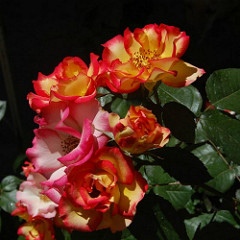

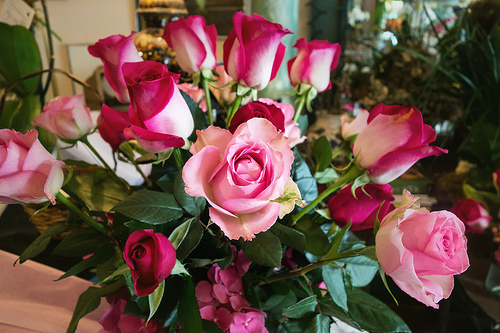

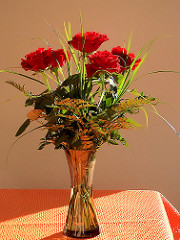

In [6]:
# Visualize dataset

roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

We already know about the Keras.ImageDataGenerator class and it's functions so we are not going to use that here. <br/>

Instead we'll use tf.data.Dataset

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels = 3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Use Dataset.map to create a dataset of image, label pairs

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())